In [1]:
!pip install --upgrade ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [2]:
import os, gc, json, shutil, yaml, warnings, random, math, copy
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os

dataset_path = "/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset"
splits = ["train", "val", "test"]

for split in splits:
    images_path = os.path.join(dataset_path, split, "images")
    num_images = len([f for f in os.listdir(images_path) if f.endswith(('.jpg','.png','.jpeg'))])
    print(f"{split.capitalize()} images: {num_images}")

total = sum(len([f for f in os.listdir(os.path.join(dataset_path, s, "images")) if f.endswith(('.jpg','.png','.jpeg'))]) for s in splits)
print(f"Total images: {total}")

Train images: 18274
Val images: 5420
Test images: 5431
Total images: 29125


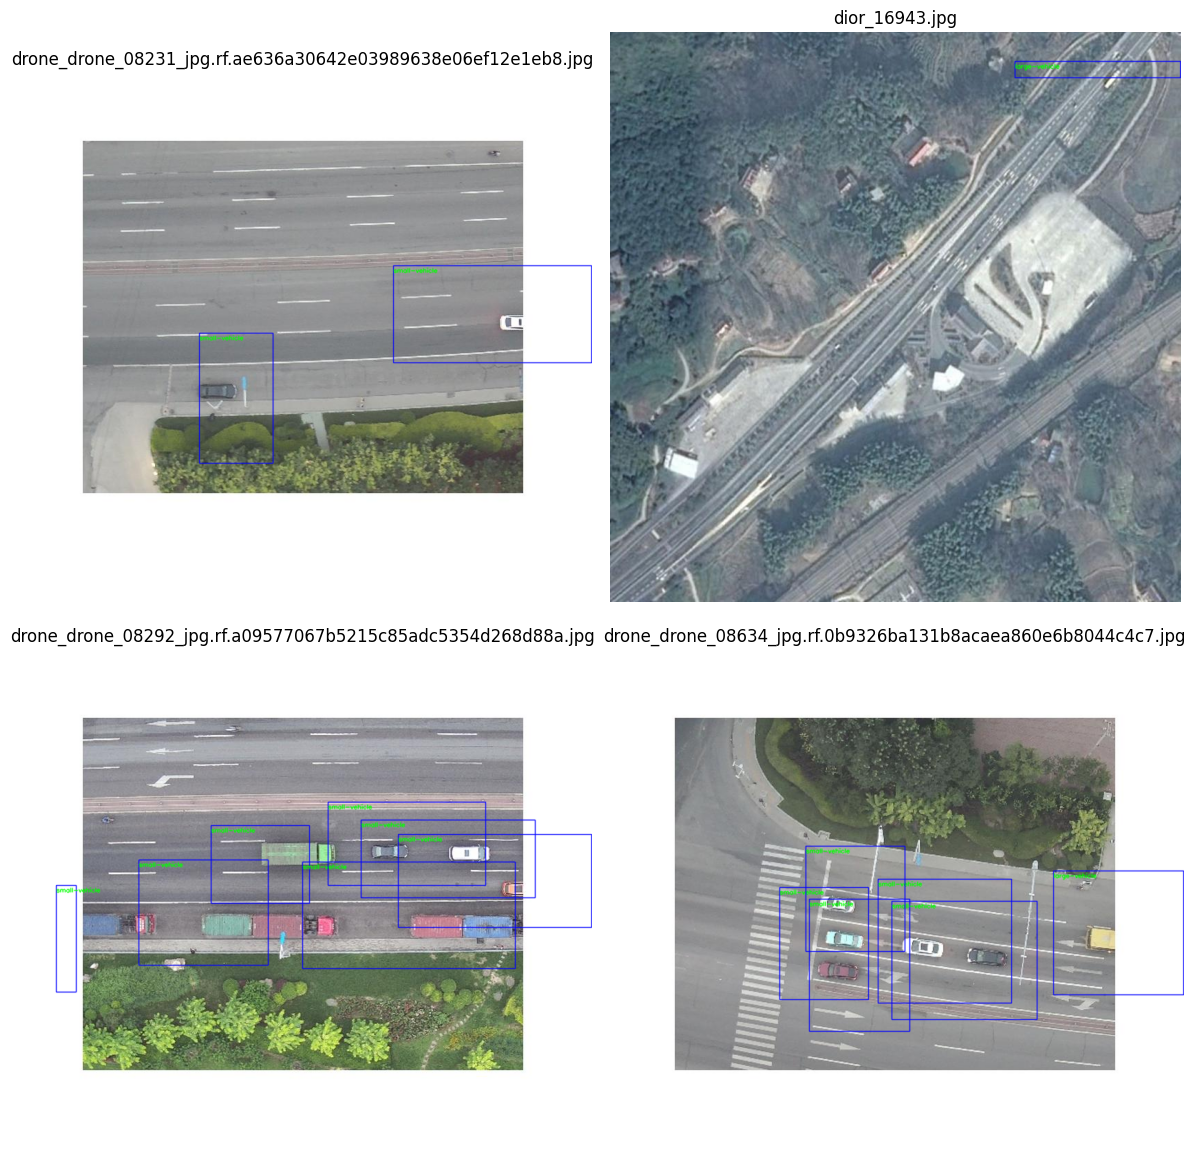

In [4]:
import os
import random
import yaml
import cv2
import matplotlib.pyplot as plt

# Paths
dataset_path = "/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset"
train_img_path = os.path.join(dataset_path, "train/images")
train_label_path = os.path.join(dataset_path, "train/labels")
yaml_file = os.path.join(dataset_path, "data.yaml")

# Load class names from YAML
with open(yaml_file, "r") as f:
    data = yaml.safe_load(f)
names = data["names"]

# Pick random images
image_files = os.listdir(train_img_path)
random_imgs = random.sample(image_files, 4)

# Plotting setup
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

for i, img_name in enumerate(random_imgs):
    img_path = os.path.join(train_img_path, img_name)
    label_path = os.path.join(train_label_path, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Load image
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    # Load labels if exists
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = [line.strip().split() for line in f.readlines()]

        for label in labels:
            cls, x, y, bw, bh = map(float, label[:5])
            cls = int(cls)

            # ✅ Shrink bounding box for very tight fit
            shrink_factor = 0.4  # 40% of original box size
            bw *= shrink_factor
            bh *= shrink_factor

            # Convert YOLO normalized coordinates to pixel coordinates
            x1 = int(max((x - bw / 2) * w, 0))
            y1 = int(max((y - bh / 2) * h, 0))
            x2 = int(min((x + bw / 2) * w, w - 1))
            y2 = int(min((y + bh / 2) * h, h - 1))

            # Draw smaller rectangle with anti-aliasing for smooth lines
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 1, lineType=cv2.LINE_AA)

            # Draw smaller text inside box if possible
            text_size = 0.3
            text_thickness = 1
            text_y = y1 + 10 if y1 + 10 < h else y1 - 5
            cv2.putText(img, names[cls], (x1, text_y),
                        cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), text_thickness, cv2.LINE_AA)

    # Show image
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title(img_name)
    ax[i].axis("off")

plt.tight_layout()
plt.show()


In [5]:
import os

# Base dataset path (update according to what the print above shows)
base_path = "/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset"

yaml_content = f"""
# YOLO Dataset Configuration File

train: {base_path}/train/images
val: {base_path}/val/images
test: {base_path}/test/images

nc: 2
names: ['small-vehicle', 'large-vehicle']
"""

yaml_path = "/kaggle/working/data.yaml"

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print("✅ data.yaml updated and saved successfully.")

✅ data.yaml updated and saved successfully.


In [6]:
import os

for root, dirs, files in os.walk("/kaggle", topdown=True):
    if "images" in dirs:
        print(os.path.join(root, "images"))

/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/val/images
/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images
/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/train/images


In [7]:
# ------------------------------------------------------------
# 2️⃣ Train YOLOv10s Model
# ------------------------------------------------------------
from ultralytics import YOLO
model = YOLO("yolov10s.pt")  # pre-trained model

results = model.train(
    data=str(yaml_path),
    epochs=20,
    imgsz=640,
    batch=16,
    project="/kaggle/working/vehicle_yolov10_train",
    name="yolov10_vehicle",
    device=0,
    workers=2,
    exist_ok=True
)

print("\n✅ Training complete. Best model saved in:")
print(model.ckpt_path)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.224 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, k

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       5420      81053      0.842      0.774      0.846      0.566
         small-vehicle       4592      71035      0.908      0.879       0.94       0.64
         large-vehicle       2394      10018      0.775       0.67      0.752      0.492
Speed: 0.2ms preprocess, 4.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/vehicle_yolov10_train/yolov10_vehicle

✅ Training complete. Best model saved in:
yolov10s.pt



image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/drone_vsai_q_DJI_0792__1024__2976___1648.png: 640x640 1 small-vehicle, 14.6ms
Speed: 2.7ms preprocess, 14.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


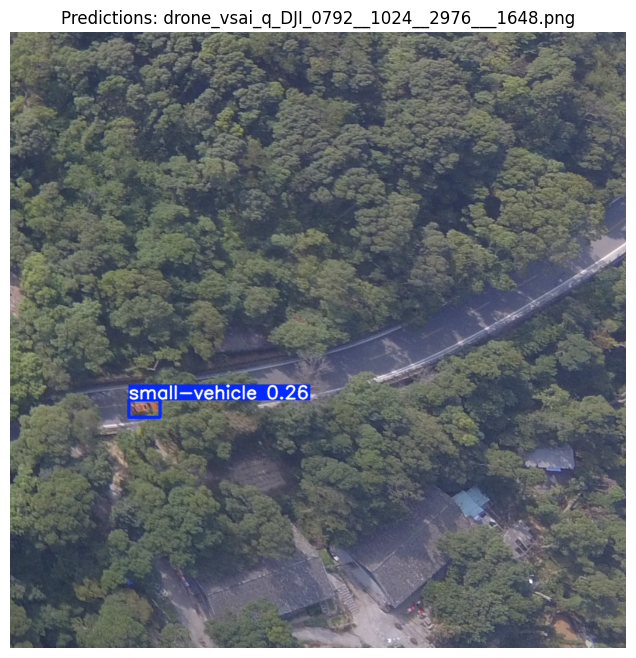


image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/dior_06593.jpg: 640x640 (no detections), 14.7ms
Speed: 3.0ms preprocess, 14.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


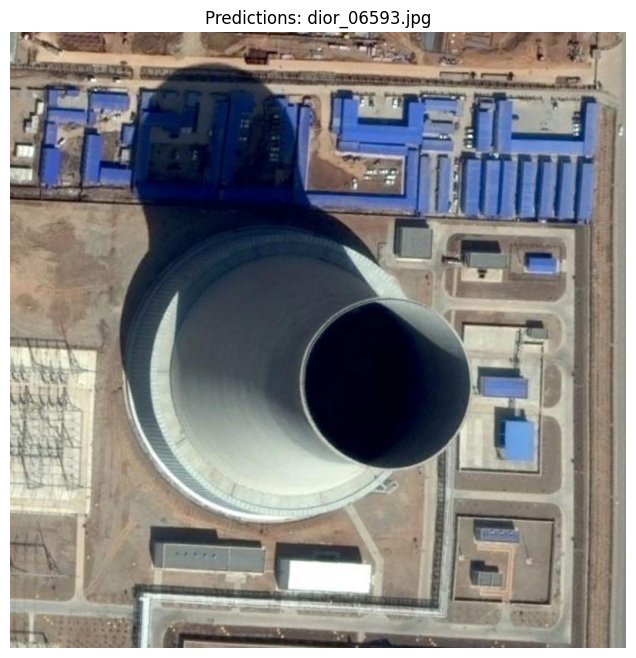


image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/drone_drone_05874_jpg.rf.458b6aeccfce4b4b4c927b5676a23aa7.jpg: 544x640 18 small-vehicles, 48.2ms
Speed: 2.5ms preprocess, 48.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


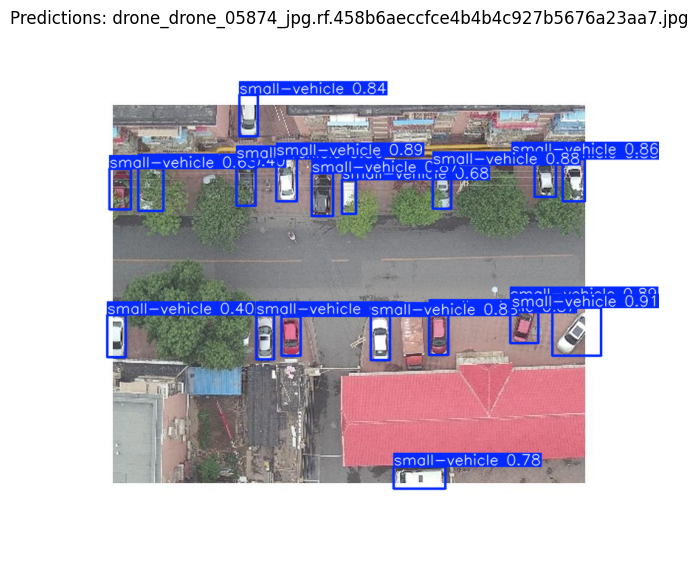


image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/drone_drone_07136_jpg.rf.9e19c4ba61a68ee67a641b84d93387dd.jpg: 544x640 11 small-vehicles, 13.9ms
Speed: 2.3ms preprocess, 13.9ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


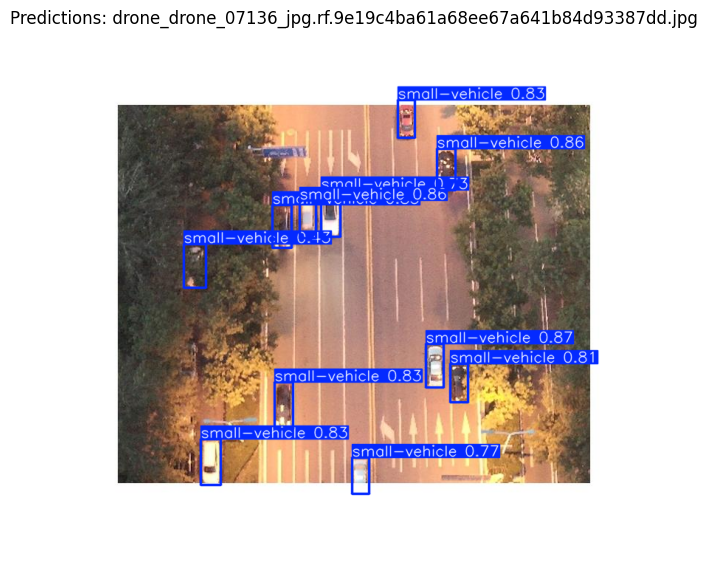


image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/drone_vsai_u_DJI_0073__1024__0___824.png: 640x640 114 small-vehicles, 15.3ms
Speed: 2.8ms preprocess, 15.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


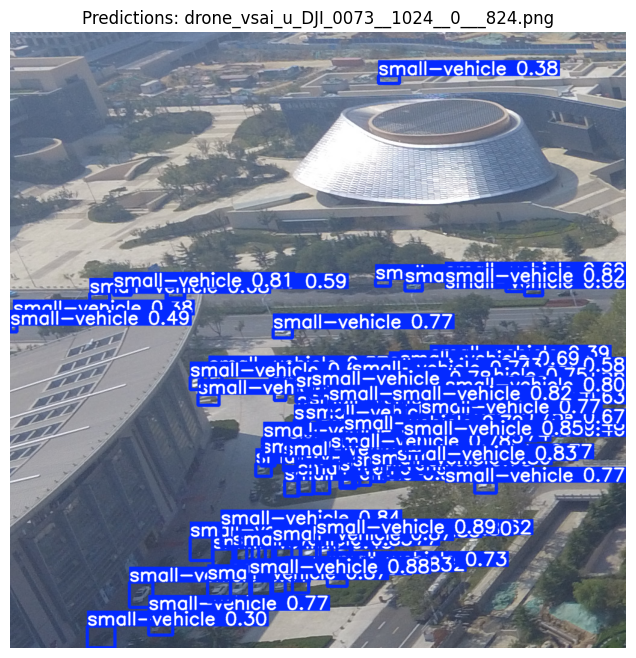

In [8]:
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2

# Load your trained YOLOv12 model
model = YOLO("/kaggle/working/vehicle_yolov10_train/yolov10_vehicle/weights/best.pt")

# ✅ Path to test images
test_images_dir = "/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images"

# Randomly pick 5 images
image_paths = os.listdir(test_images_dir)
random_images = random.sample(image_paths, 5)

# Show predictions
for img_name in random_images:
    img_path = os.path.join(test_images_dir, img_name)
    results = model.predict(img_path, conf=0.25)

    # Visualize predictions
    res_plotted = results[0].plot()  # plotted NumPy image (BGR)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
    plt.title(f"Predictions: {img_name}")
    plt.axis("off")
    plt.show()

In [9]:
from ultralytics import YOLO
import numpy as np

# Load best trained model
model = YOLO("/kaggle/working/vehicle_yolov10_train/yolov10_vehicle/weights/best.pt")

# Evaluate the model on the validation set
metrics = model.val()

# Helper function to safely extract scalar values
def get_scalar(value):
    if isinstance(value, (np.ndarray, list)):
        return float(np.mean(value))  # take average if array
    return float(value)

# Extract metrics
map50 = get_scalar(metrics.box.map50)
map5095 = get_scalar(metrics.box.map)
precision = get_scalar(metrics.box.p)
recall = get_scalar(metrics.box.r)
f1 = get_scalar(metrics.box.f1)

# Print results
print("\n📊 Model Evaluation Results:")
print(f"Model Name       : {model.model.name if hasattr(model.model, 'name') else 'YOLOv10 Vehicle Model'}")
print(f"mAP@0.5          : {map50:.4f}")
print(f"mAP@0.5:0.95     : {map5095:.4f}")
print(f"Precision        : {precision:.4f}")
print(f"Recall           : {recall:.4f}")
print(f"F1-Score         : {f1:.4f}")

Ultralytics 8.3.224 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,218,774 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 410.5±501.0 MB/s, size: 692.3 KB)
val: Scanning /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/val/labels... 5420 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5420/5420 202.3it/s 26.8s
WARNING ⚠️ val: Cache directory /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/val is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 339/339 4.6it/s 1:13


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       5420      81053      0.842      0.774      0.846      0.566
         small-vehicle       4592      71035      0.909      0.878       0.94      0.641
         large-vehicle       2394      10018      0.776       0.67      0.752      0.492
Speed: 1.0ms preprocess, 8.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

📊 Model Evaluation Results:
Model Name       : YOLOv10 Vehicle Model
mAP@0.5          : 0.8456
mAP@0.5:0.95     : 0.5664
Precision        : 0.8422
Recall           : 0.7741
F1-Score         : 0.8061


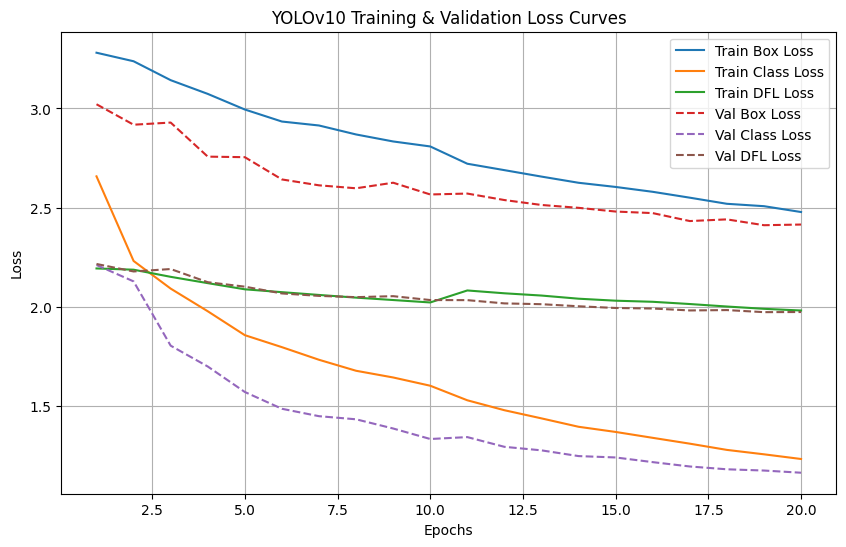

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to results CSV file generated automatically
csv_path = "/kaggle/working/vehicle_yolov10_train/yolov10_vehicle/results.csv"

# Read CSV data
df = pd.read_csv(csv_path)

# Plot losses
plt.figure(figsize=(10,6))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="Train DFL Loss")
plt.plot(df["epoch"], df["val/box_loss"], '--', label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], '--', label="Val Class Loss")
plt.plot(df["epoch"], df["val/dfl_loss"], '--', label="Val DFL Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("YOLOv10 Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()